# ISYE/Math/CS 425 - Final - Helper
- Bryan Luu

All code in Julia 1.5.2

## Contents
- [Helper Functions](#Helper-Functions)
- [Max-Flow](#Max-Flow)
- [Optimal Matchings](#Optimal-Matchings)
- [TSP](#TSP)

Import libraries used

In [1]:
using LightGraphs, MetaGraphs, LightGraphsMatching, GraphRecipes, Plots

## Helper Functions

In [306]:
# connects adjacent vertices in list of vertices P
connect(P::Vector{Int}) = [Edge(u, v) for (u, v) in zip(P[1:end-1], P[2:end])];
# checks if vertex v is incident to edge e
incident(v::Int, e::T) where {T <: AbstractEdge} = e.src == v || e.dst == v; 
# prints a sum: x[1] + x[2] + ... = sum(x)
sum_str(x::Vector{N}) where {N <: Number} = join(x, " + ") * " = $(sum(x))";
 # get the weight list of the edgelist from the weight dictionary
wts(E::Vector{T}, 
    wd::Dict{Tuple{Int, Int}, N}) where {T <: AbstractEdge, N <: Number} = [wd[(e.src, e.dst)] for e in E];
 # function to convert array into array of symbols
to_sym(v::Array) = map(x->Symbol(x), v);

# E list of Edges in a path, topologically sorted (i.e. E[1] -> E[2] -> ... -> E[end])
function disconnect(E::Vector{T}) where {T <: AbstractEdge}
    path = []
    s = nothing;
    for e in E
        s, d = e.src, e.dst;
        push!(path, s);
        s = d;
    end
    push!(path, s);
    return path
end

# Similar to Base.unique except includes options for undirected edges
function unique(E::Vector{T}; directed=false) where {T <: AbstractEdge}
    tmp = copy(E);
    new = T[];
    while !isempty(tmp)
        e = pop!(tmp);
        removed = remove!(e, tmp; directed=directed);
        push!(new, e);
    end
    return new;
end

# Returns a normalized x where (min(x), max(x)) -> (0, 1)
function normalize(x::N) where {N <: Union{Real, Array{<:Real}}}
    mx, Mx = min(x...), max(x...); # limits
    return Mx == mx ? x.*0 : (x.-mx)./(Mx .- mx)
end

# Set the position metadata of vertex v
function place!(mg::G, v::Int, 
        position::Tuple{T, N}) where {G <: Union{MetaGraph, MetaDiGraph}, T <: Real, N <: Real}
    set_prop!(mg, v, :position, position);
end

# Add edge between vertex u, v in MetaGraph mg, with weight metadata,
# updating the weight dictionary if given.
function connect!(mg::G, u::Int, v::Int, weight::N; 
        wd::D=nothing) where {G <: Union{MetaGraph, MetaDiGraph}, N <: Real, D <: Union{Nothing, Dict}}
    add_edge!(mg, u, v);
    set_prop!(mg, u, v, :weight, weight);
    if wd != nothing
        wd[(u, v)] = wd[(v, u)] = weight;
    end
end

# Remove edge e from a copy of edge list E, with a default flag for undirected edges
function remove(e::T, E::Vector{T}; directed::Bool=false, 
        condition=(k)->(k == e || (!directed && k == reverse(e)))) where {T <: AbstractEdge}
    return [k for k in E if !condition(k)];
end

# Remove edge e from edge list E in place, with a default flag for undirected edges
# Returns any edges removed
function remove!(e::T, E::Vector{T}; directed::Bool=false, 
        condition=(k)->(k == e || (!directed && k == reverse(e)))) where {T <: AbstractEdge}
    i = 1;
    removed = T[]
    while i <= length(E)
        if condition(E[i])
            push!(removed, popat!(E, i));
            continue;
        end
        i += 1;
    end
    return removed;
end

# Returns an edge-weight function that emphasizes the edges in edgelist E,
function emphasize(E::Vector{T}; in_weight=3, out_weight=1, directed=false) where {T <: AbstractEdge}
    function ew(s, d, w)
        e = Edge(s, d);
        re = reverse(e);
        if in(e, E) || (!directed && in(re, E))
            return in_weight;
        else
            return out_weight;
        end
    end
    return ew;
end;

# Helper function to plot the given metagraph with fixed positions
function plot_fixed(g::G; names=vertices(g), positions=[], 
        ew=(s, d, w)->1, args...) where {G <: Union{MetaGraph, MetaDiGraph}}
    N = nv(g);

    mg = copy(g); # create internal connected copy
    fake = Dict();
    if !is_connected(mg)
        for v in 2:N
            if is_connected(mg)
                break
            end
            add_edge!(mg, 1, v);
            fake[1, v] = true;
        end
    end

    new_ew(s, d, w) = get(fake, (s, d), false) ? 0 : ew(s, d, w);

    if isempty(positions)
        positions = [get_prop(g, v, :position) for v in 1:N];
    end
    
    x = [pos[1] for pos in positions];
    y = [pos[2] for pos in positions]; # Flip the y so that (0,0) is bottom-left.
    
    p = hcat(x, y); # Position
    sp = normalize(p); # Scale so that the positions are normalized
    
    graphplot(mg; x=sp[:, 1], y=sp[:, 2], names=names, ew=new_ew, args...);
end;

## Max Flow
- [Max-Flow Functions](#Max-Flow-Functions)
- [Max-Flow Input](#Max-Flow-Input)

### Max-Flow Functions

In [3]:
# calculate the flow into vertex v given flows x
function flow(x::Dict{T, N}, v::Int) where {T <: Union{AbstractEdge, Tuple{Int, Int}}, N <: Real}
    E = keys(x);
    inflow = sum(N[x[e] for e in E if e.dst==v]);
    outflow = sum(N[x[e] for e in E if e.src==v]);
    inflow - outflow
end;

In [4]:
# Bread-first-search for (u,v)-path in the graph defined by graph g
function BFS(g::G, u::Int, v::Int) where {G <: AbstractGraph}
    p = Dict{Int, Int}(zip(vertices(g), -1*ones(nv(g))));
    p[u] = 0;
    q = Int[u]; # queue for BFS
    while !isempty(q)
        curr = popfirst!(q);
        if curr == v
            break
        end
        for n in neighbors(g, curr)
            if p[n] == -1
                push!(q, n);
                p[n] = curr;
            end
        end
    end
    i = v;
    path = Int[];
    while(i != u)
        if p[i] == -1
            return Int[]
        else
            pushfirst!(path, i);
            i = p[i];
        end
    end
    pushfirst!(path, u);
    return path
end;

In [5]:
# Construct auxiliary graph of metagraph from flow x
function auxiliary_graph(mg::MetaDiGraph, x::Dict{T, N}) where {T <: AbstractEdge, N <: Real}
    aux = copy(mg);
    # Construct capacities
    u = Dict(e => get_prop(mg, e, :weight) for e in edges(mg));
    for e in edges(mg)
        rem_edge!(aux, e); # Delete the existing edge first
        if x[e] < u[e]
            add_edge!(aux, e); # add forward arc
            set_prop!(aux, e, :forward, true); # set edge to a forward arc
        end
        if x[e] > 0
            rev = reverse(e);
            add_edge!(aux, rev); # add a reverse arc
            set_prop!(aux, rev, :reverse, true); # set edge as reverse arc
        end
    end
    return aux;
end;

In [17]:
# Augmenting path algorithm for metagraph mg with capacities defined by edge weights, and start r and end s.
function APA(mg::MetaDiGraph, r::Int, s::Int; names::Vector{T}=Vector(1:nv(mg)), 
        verbose::Bool=false, show_graphs::Bool=false) where {T <: Union{String, Symbol, Int}}
    log(msg::Any) = verbose ? println(msg) : nothing # printer
    isreverse(aux::MetaDiGraph, e::T) where {T <: AbstractEdge} = has_prop(aux, e, :reverse);
    isforward(aux::MetaDiGraph, e::T) where {T <: AbstractEdge} = has_prop(aux, e, :forward);
    ename(e::T) where {T <: AbstractEdge} = "$(names[e.src]), $(names[e.dst])";
    
    # Construct capacities
    u = Dict(e => get_prop(mg, e, :weight) for e in edges(mg));
    u_max = max(values(u)...) # max capacity
    
    # Construct flow vector
    x = Dict{edgetype(mg), valtype(u)}(zip(edges(mg), zeros(ne(mg))));
    
    # Returns a scaled flow where x=0 -> low and x=max_flow -> high
    function flow_ew(low::T, high::N; max_flow=u_max) where {T <: Real, N <: Real}
        if max_flow == Inf
            return (s, d, w) -> high;
        end
        return (s, d, w) -> low + (max_flow == 0 ? 0 : (high-low)*x[Edge(s, d)]/max_flow);
    end
    plot_flow(g::MetaDiGraph; ew=flow_ew(0.5, 3), 
        args...) = plot_fixed(g; ew=ew, names=names, curvature=0.005, args...);
    # IJulia only... inline display
    function show_plot(plt; title="")
        show_graphs || return; # return if show_graphs=false
        title!(plt, title);
        display(Main.IJulia.InlineDisplay(), plt);
    end
    
    log("---Setup---")
    log("Edge\tu, x")
    for e in edges(mg)
        log(ename(e) * ":\t$(u[e]), $(x[e])")
    end
    show_plot(plot_flow(mg; ew=(s, d, w)->1, el=Dict((e.src, e.dst)=>"$(u[e])" for e in edges(mg)), 
            elb=false, elo=0.01), title="Input graph");
    
    # Construct auxiliary digraph
    aux = auxiliary_graph(mg, x);
    
    path = BFS(aux, r, s);
    arcs = connect(path);
    i = 1;
    while(!isempty(path))
        log("---Iteration $(i)---")
        show_plot(plot_flow(aux; ew=emphasize(arcs; directed=true)), title="Auxiliary graph at iteration $(i)");
        log("x-augmenting path: " * join(map((v)->string(names[v]), path), ", "))

        # find x-width
        eps1 = min(Inf, [u[e] - x[e] for e in arcs if isforward(aux, e)]...);
        eps2 = min(Inf, [x[reverse(e)] for e in arcs if isreverse(aux, e)]...);
        log("ε1: $(eps1)")
        log("ε2: $(eps1)")
        x_width = min(eps1, eps2);
        
        log("x-width: $(x_width)")

        if x_width == Inf
            break
        end

        for e in arcs
            if isforward(aux, e)
                x[e] += x_width; # increase flow on forward arcs
            end
            if isreverse(aux, e)
                x[reverse(e)] -= x_width; # decrease flow on reverse arcs
            end
        end

        log("Edge\tu, x")
        for e in edges(mg)
            log(ename(e) * ":\t$(u[e]), $(x[e])")
        end
        
        max_flow = (u_max == Inf ? min([u[e] for e in arcs]...) : u_max);
        show_plot(plot_flow(mg; ew=flow_ew(0.5, 3; max_flow=max_flow), 
                el=Dict((e.src, e.dst)=>"$(u[e]), $(x[e])" for e in edges(mg)), 
                elo=0.025, elb=false), 
            title="Flow at iteration $(i)");

        # Create auxiliary graph from flows
        aux = auxiliary_graph(mg, x);
        log("Auxiliary graph: ")
        for e in edges(aux)
            log("$(names[e.src]) => $(names[e.dst])")
        end
        
        path = BFS(aux, r, s);
        arcs = connect(path);
        i += 1;
    end

    show_plot(plot_flow(aux; ew=emphasize(arcs; directed=true)), title="Final auxiliary graph");
    log("No augmenting path left...")
    
    max_flow = flow(x, s);
                           
    log("===== OPTIMUM FOUND =====")
    log("Max-flow: $(max_flow)")
    show_plot(plot_flow(mg, el=Dict((e.src, e.dst)=>"$(u[e]), $(x[e])" for e in edges(mg)), 
                elo=0.025, elb=false), 
            title="Optimal Flow");
                                    
    return (max_flow, x);
end;

### Max-Flow Input

In [24]:
V_str = "rpbacsqd"; # String representing all nodes
names = to_sym(collect(V_str)); # Node names
V = Vector(1:length(V_str)); # Node indices
index = Dict(names[i] => i for i in V); # Map from names to indices

L = Dict{Symbol, Any}(zip(names, [[] for v in V])); # Adjacency list
L[:r] = [:p, :a, :q];
L[:p] = [:q, :b];
L[:b] = [:a, :s];
L[:a] = [:c, :d];
L[:c] = [:q, :s, :b];
L[:q] = [:p, :b, :d];
L[:d] = [:c, :s];

Lu = Dict{Symbol, Any}(zip(names, [[] for v in V])); # Capacities in Adjacency List form
Lu[:r] = [6, 9, 4];
Lu[:p] = [2, 3];
Lu[:b] = [1, 8];
Lu[:a] = [8, 1];
Lu[:c] = [1, 4, 2];
Lu[:q] = [1, 2, 6];
Lu[:d] = [1, 6];

# Create metagraph
mg = MetaDiGraph(length(V_str));
for i in names
    for (k, j) in enumerate(L[i])
        s, d = index[i], index[j];
        add_edge!(mg, s, d);
        set_prop!(mg, s, d, :weight, Lu[i][k]);
    end
end

# Position vertices
place!(mg, index[:r], (0, 0));
place!(mg, index[:p], (1, 2));
place!(mg, index[:q], (2, -2));
place!(mg, index[:a], (2.3, 0.5));
place!(mg, index[:c], (3.5, 0));
place!(mg, index[:b], (3.6, 2));
place!(mg, index[:d], (4.4, -2));
place!(mg, index[:s], (5.5, 0));

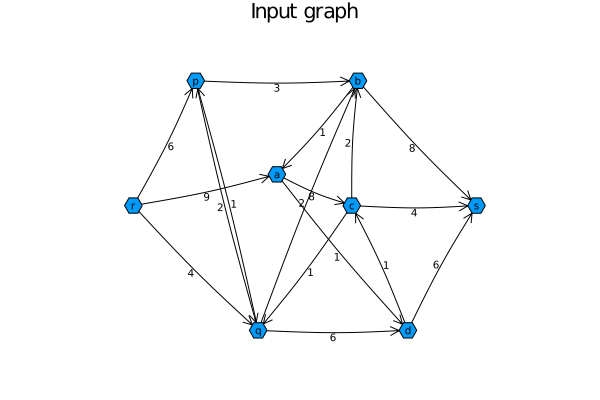

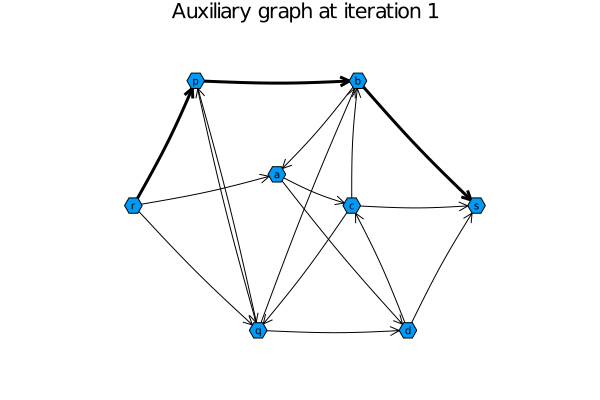

---Setup---
Edge	u, x
r, p:	6, 0
r, a:	9, 0
r, q:	4, 0
p, b:	3, 0
p, q:	2, 0
b, a:	1, 0
b, s:	8, 0
a, c:	8, 0
a, d:	1, 0
c, b:	2, 0
c, s:	4, 0
c, q:	1, 0
q, p:	1, 0
q, b:	2, 0
q, d:	6, 0
d, c:	1, 0
d, s:	6, 0
---Iteration 1---


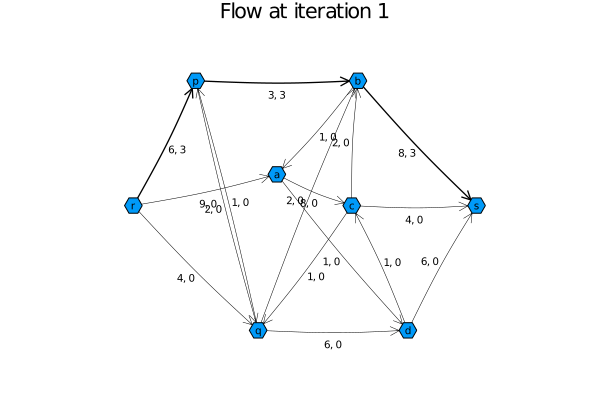

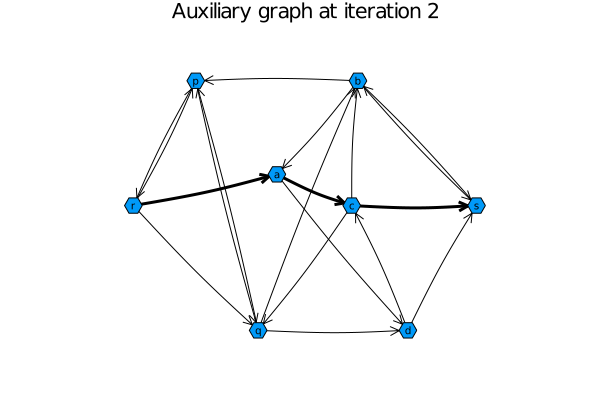

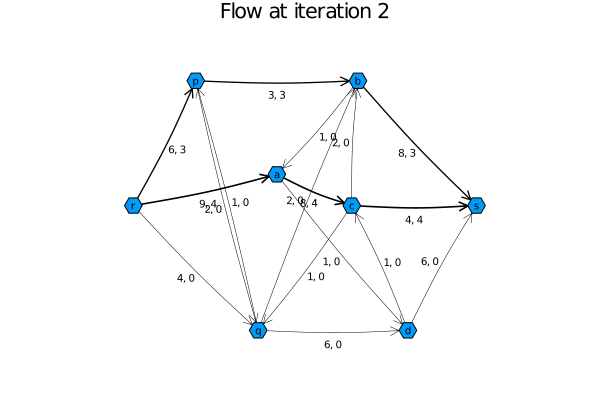

x-augmenting path: r, p, b, s
ε1: 3.0
ε2: 3.0
x-width: 3.0
Edge	u, x
r, p:	6, 3
r, a:	9, 0
r, q:	4, 0
p, b:	3, 3
p, q:	2, 0
b, a:	1, 0
b, s:	8, 3
a, c:	8, 0
a, d:	1, 0
c, b:	2, 0
c, s:	4, 0
c, q:	1, 0
q, p:	1, 0
q, b:	2, 0
q, d:	6, 0
d, c:	1, 0
d, s:	6, 0
Auxiliary graph: 
r => p
r => a
r => q
p => r
p => q
b => p
b => a
b => s
a => c
a => d
c => b
c => s
c => q
s => b
q => p
q => b
q => d
d => c
d => s
---Iteration 2---
x-augmenting path: r, a, c, s
ε1: 4.0
ε2: 4.0
x-width: 4.0
Edge	u, x
r, p:	6, 3
r, a:	9, 4
r, q:	4, 0
p, b:	3, 3
p, q:	2, 0
b, a:	1, 0
b, s:	8, 3
a, c:	8, 4
a, d:	1, 0
c, b:	2, 0
c, s:	4, 4
c, q:	1, 0
q, p:	1, 0
q, b:	2, 0
q, d:	6, 0
d, c:	1, 0
d, s:	6, 0


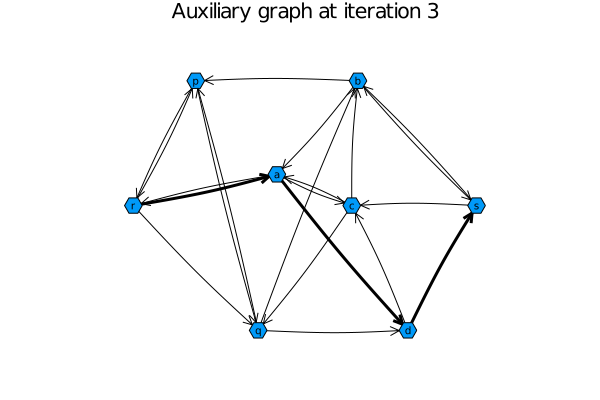

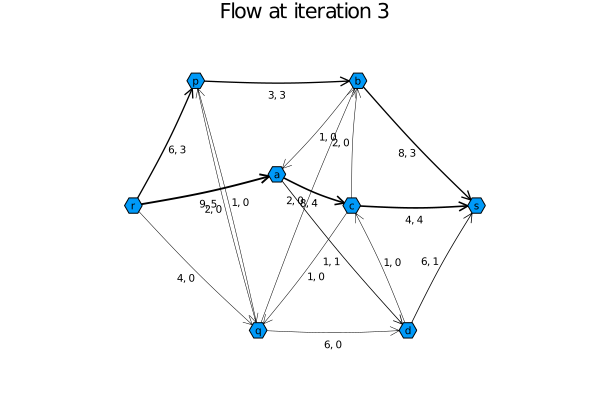

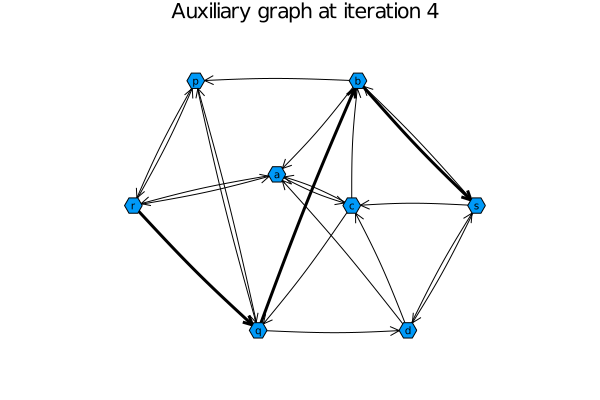

Auxiliary graph: 
r => p
r => a
r => q
p => r
p => q
b => p
b => a
b => s
a => r
a => c
a => d
c => b
c => a
c => q
s => b
s => c
q => p
q => b
q => d
d => c
d => s
---Iteration 3---
x-augmenting path: r, a, d, s
ε1: 1.0
ε2: 1.0
x-width: 1.0
Edge	u, x
r, p:	6, 3
r, a:	9, 5
r, q:	4, 0
p, b:	3, 3
p, q:	2, 0
b, a:	1, 0
b, s:	8, 3
a, c:	8, 4
a, d:	1, 1
c, b:	2, 0
c, s:	4, 4
c, q:	1, 0
q, p:	1, 0
q, b:	2, 0
q, d:	6, 0
d, c:	1, 0
d, s:	6, 1
Auxiliary graph: 
r => p
r => a
r => q
p => r
p => q
b => p
b => a
b => s
a => r
a => c
c => b
c => a
c => q
s => b
s => c
s => d
q => p
q => b
q => d
d => a
d => c
d => s
---Iteration 4---


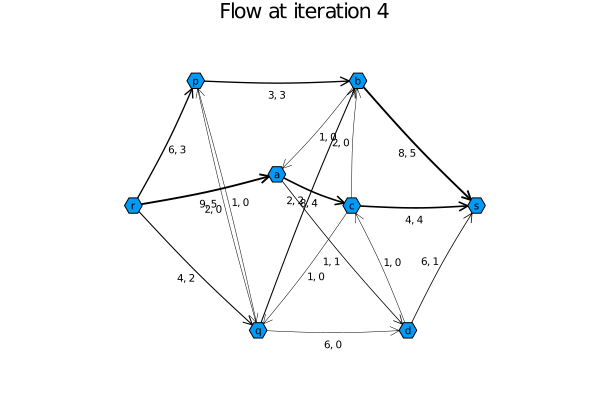

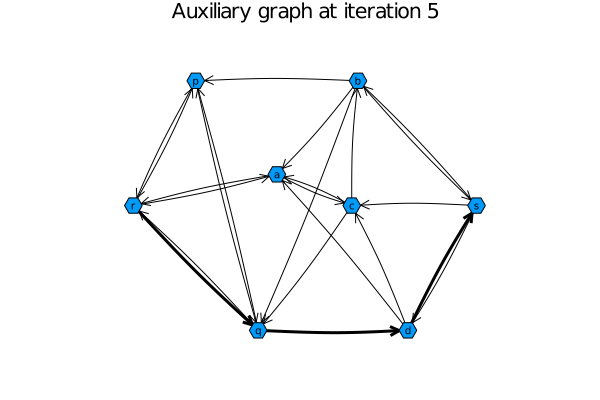

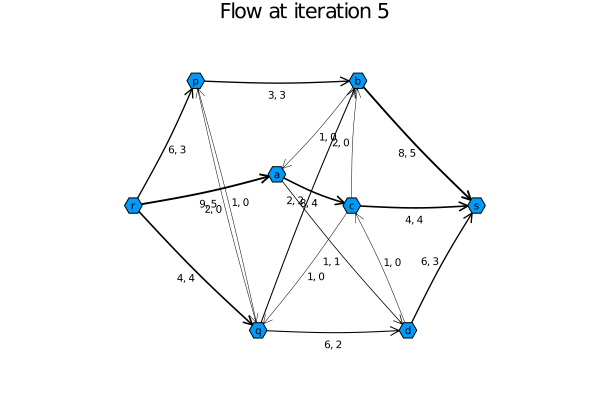

x-augmenting path: r, q, b, s
ε1: 2.0
ε2: 2.0
x-width: 2.0
Edge	u, x
r, p:	6, 3
r, a:	9, 5
r, q:	4, 2
p, b:	3, 3
p, q:	2, 0
b, a:	1, 0
b, s:	8, 5
a, c:	8, 4
a, d:	1, 1
c, b:	2, 0
c, s:	4, 4
c, q:	1, 0
q, p:	1, 0
q, b:	2, 2
q, d:	6, 0
d, c:	1, 0
d, s:	6, 1
Auxiliary graph: 
r => p
r => a
r => q
p => r
p => q
b => p
b => a
b => s
b => q
a => r
a => c
c => b
c => a
c => q
s => b
s => c
s => d
q => r
q => p
q => d
d => a
d => c
d => s
---Iteration 5---
x-augmenting path: r, q, d, s
ε1: 2.0
ε2: 2.0
x-width: 2.0
Edge	u, x
r, p:	6, 3
r, a:	9, 5
r, q:	4, 4
p, b:	3, 3
p, q:	2, 0
b, a:	1, 0
b, s:	8, 5
a, c:	8, 4
a, d:	1, 1
c, b:	2, 0
c, s:	4, 4
c, q:	1, 0
q, p:	1, 0
q, b:	2, 2
q, d:	6, 2
d, c:	1, 0
d, s:	6, 3


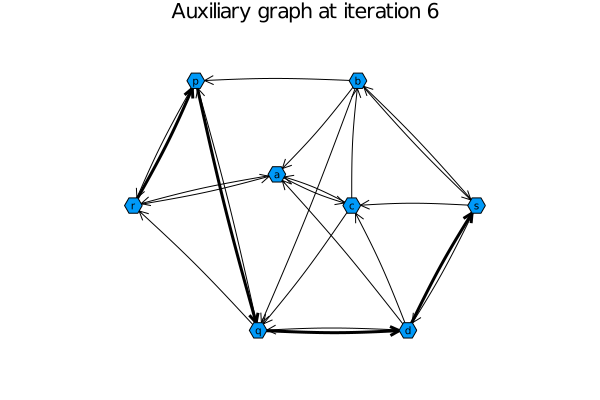

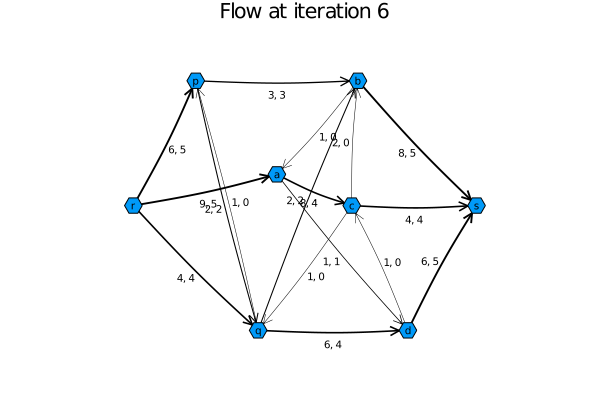

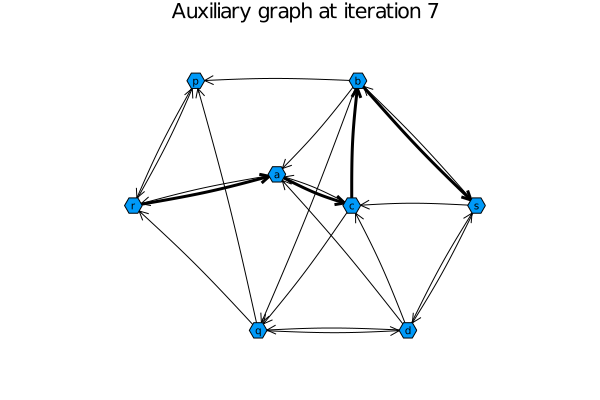

Auxiliary graph: 
r => p
r => a
p => r
p => q
b => p
b => a
b => s
b => q
a => r
a => c
c => b
c => a
c => q
s => b
s => c
s => d
q => r
q => p
q => d
d => a
d => c
d => s
d => q
---Iteration 6---
x-augmenting path: r, p, q, d, s
ε1: 2.0
ε2: 2.0
x-width: 2.0
Edge	u, x
r, p:	6, 5
r, a:	9, 5
r, q:	4, 4
p, b:	3, 3
p, q:	2, 2
b, a:	1, 0
b, s:	8, 5
a, c:	8, 4
a, d:	1, 1
c, b:	2, 0
c, s:	4, 4
c, q:	1, 0
q, p:	1, 0
q, b:	2, 2
q, d:	6, 4
d, c:	1, 0
d, s:	6, 5
Auxiliary graph: 
r => p
r => a
p => r
b => p
b => a
b => s
b => q
a => r
a => c
c => b
c => a
c => q
s => b
s => c
s => d
q => r
q => p
q => d
d => a
d => c
d => s
d => q
---Iteration 7---


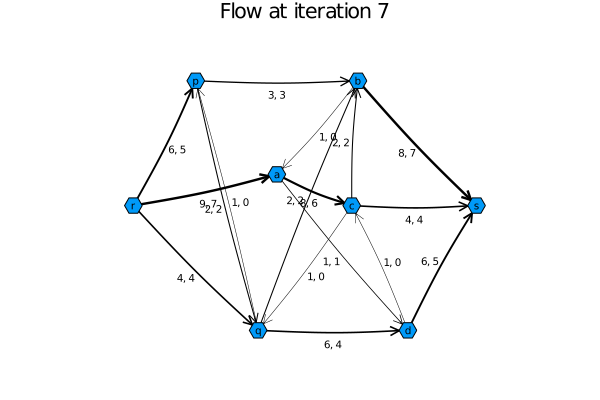

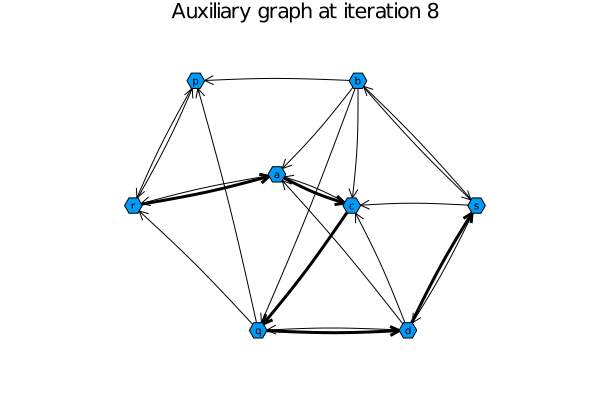

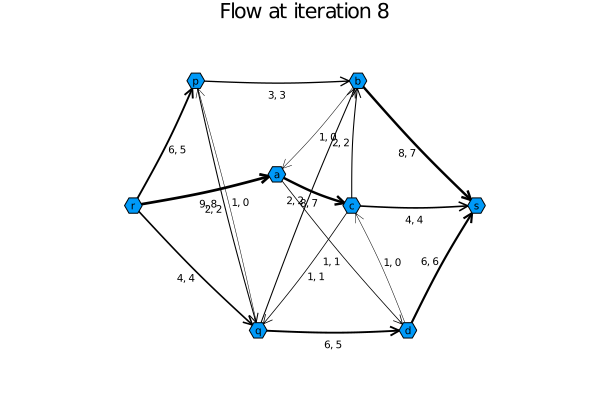

x-augmenting path: r, a, c, b, s
ε1: 2.0
ε2: 2.0
x-width: 2.0
Edge	u, x
r, p:	6, 5
r, a:	9, 7
r, q:	4, 4
p, b:	3, 3
p, q:	2, 2
b, a:	1, 0
b, s:	8, 7
a, c:	8, 6
a, d:	1, 1
c, b:	2, 2
c, s:	4, 4
c, q:	1, 0
q, p:	1, 0
q, b:	2, 2
q, d:	6, 4
d, c:	1, 0
d, s:	6, 5
Auxiliary graph: 
r => p
r => a
p => r
b => p
b => a
b => c
b => s
b => q
a => r
a => c
c => a
c => q
s => b
s => c
s => d
q => r
q => p
q => d
d => a
d => c
d => s
d => q
---Iteration 8---
x-augmenting path: r, a, c, q, d, s
ε1: 1.0
ε2: 1.0
x-width: 1.0
Edge	u, x
r, p:	6, 5
r, a:	9, 8
r, q:	4, 4
p, b:	3, 3
p, q:	2, 2
b, a:	1, 0
b, s:	8, 7
a, c:	8, 7
a, d:	1, 1
c, b:	2, 2
c, s:	4, 4
c, q:	1, 1
q, p:	1, 0
q, b:	2, 2
q, d:	6, 5
d, c:	1, 0
d, s:	6, 6


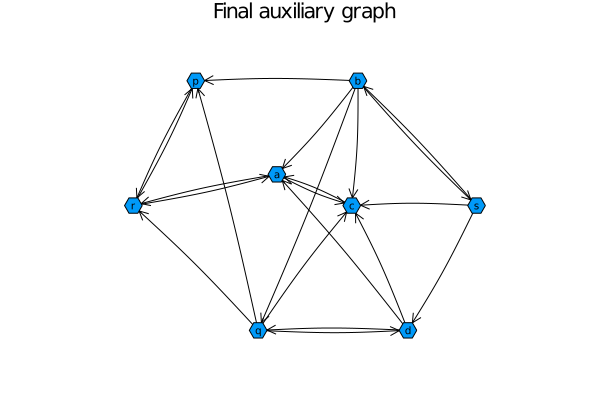

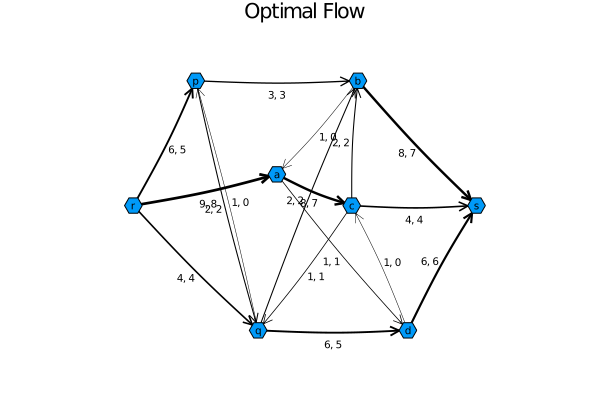

Auxiliary graph: 
r => p
r => a
p => r
b => p
b => a
b => c
b => s
b => q
a => r
a => c
c => a
s => b
s => c
s => d
q => r
q => p
q => c
q => d
d => a
d => c
d => q
No augmenting path left...
===== OPTIMUM FOUND =====
Max-flow: 17


In [22]:
max_flow, x = APA(mg, index[:r], index[:s], names=names, verbose=true, show_graphs=true);

## Optimal Matchings

## TSP
- [Christofide's Algorithm](#Christofide's-Algorithm)
- [Christofide's Input](#Christofide's-Input)

### Christofide's Algorithm

In [300]:
function Christofides(mg::MetaGraph;
        show_graphs::Bool=false, verbose::Bool=false, 
        names::Vector{S}=Vector(1:nv(mg)), args...) where {S <: Union{String, Symbol, Int}}
    
    ename(e::T) where {T <: AbstractEdge} = "$(names[e.src]) <=> $(names[e.dst])";
    log(msg::Any) = verbose ? println(msg) : nothing # printer
    function show_plot(plt; title="")
        show_graphs || return; # return if show_graphs=false
        title!(plt, title);
        display(Main.IJulia.InlineDisplay(), plt);
    end
    
    # Dictionary of weights
    wd = Dict((e.src, e.dst) => get_prop(mg, e, :weight) for e in edges(mg));
    for e in edges(mg)
        re = reverse(e);
        wd[re.src, re.dst] = wd[e.src, e.dst]; # add reverse edges too
    end
    
    show_plot(plot_fixed(mg; names=names, el=wd, curvature=0.01, args...), title="Input graph G");
    
    mst_edges = kruskal_mst(mg); # get MST
    T, Tmap = induced_subgraph(mg, mst_edges);
    log("c(T): " * sum_str(wts(mst_edges, wd)));
    show_plot(plot_fixed(mg; el=Dict((e.src, e.dst)=>wd[e.src, e.dst] for e in mst_edges), 
        ew=emphasize(mst_edges; in_weight=3, out_weight=0.2), curvature=0, names=names, args...),
        title="MST T");
    
    W = S[];
    for v in vertices(T)
        deg = degree(T, v);
        log("deg($(names[Tmap[v]])) = $(deg)")
        if deg % 2 == 1
            push!(W, Tmap[v])
        end
    end
    log("W (odd-degree nodes in T): " * join(W, ", "))
    
    sg, Wmap = induced_subgraph(mg, W);
    match = minimum_weight_perfect_matching(SimpleGraph(sg), 
        Dict(e => wd[Wmap[e.src], Wmap[e.dst]] for e in edges(sg)));
    el = Dict([(e.src, e.dst)=>wd[Wmap[e.src], Wmap[e.dst]] for e in edges(sg)]...);
    for e in edges(sg)
        el[e.dst, e.src] = wd[Wmap[e.src], Wmap[e.dst]]; # add reverse edges
    end
    inv_Wmap = Dict(v => i for (i, v) in enumerate(Wmap)); # Inverse W map
    M = unique([Edge(Wmap[v], Wmap[match.mate[v]]) for v in vertices(sg)]);
    log("Matching M:\n" * join(["$(names[e.src]) <=> $(names[e.dst])" for e in M], "\n"))
    log("c(M): " * sum_str(wts(M, wd)))
    show_plot(plot_fixed(sg; ew=emphasize(map((e)->Edge(inv_Wmap[e.src], inv_Wmap[e.dst]), M); out_weight=0.2),
            el=el, pos=[get_prop(mg, Wmap[v], :position) for v in vertices(sg)],
            curvature=0, names=Wmap, args...), title="Min-cost Matching M of G[W]");
    
    C = unique([mst_edges..., M...]); # Euler circuit with M + mst
    cg, Cmap = induced_subgraph(mg, C);
    show_plot(plot_fixed(mg; ew=emphasize(C; out_weight=0.2), el=wd, curvature=0,
            names=names, args...), title="T + M")
    
    log("Combined T + M:")
    log(join(["$(ename(e))" for e in C], "\n"))
    return C;
end;

### Christofide's Input

In [311]:
mg = MetaGraph(SimpleGraph(8));

wd = Dict{Tuple{Int, Int}, Float64}();

positions = Dict();
positions[1] = (0,0); positions[2] = (2,0); positions[3] = (4,0);
positions[4] = (1,-2); positions[5] = (3,-2);
positions[6] = (-0.5,-3); positions[7] = (1,-3.5); positions[8] = (4,-3);
for (v, pos) in positions
    x, y = pos;
    place!(mg, v, (x, y));
end

connect!(mg, 1, 2, 11; wd=wd);
connect!(mg, 2, 3, 11; wd=wd);
connect!(mg, 1, 4, 4; wd=wd);
connect!(mg, 1, 6, 7; wd=wd);
connect!(mg, 2, 4, 7; wd=wd);
connect!(mg, 2, 5, 6; wd=wd);
connect!(mg, 3, 5, 5; wd=wd);
connect!(mg, 3, 8, 6; wd=wd);
connect!(mg, 4, 5, 1; wd=wd);
connect!(mg, 4, 6, 3; wd=wd);
connect!(mg, 4, 7, 9; wd=wd);
connect!(mg, 5, 8, 2; wd=wd);
connect!(mg, 6, 7, 7; wd=wd);
connect!(mg, 7, 8, 11; wd=wd);

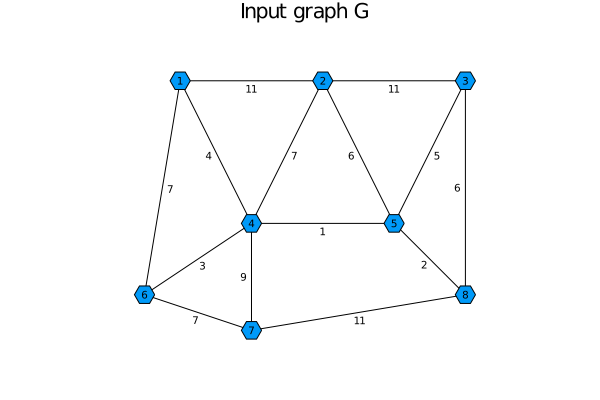

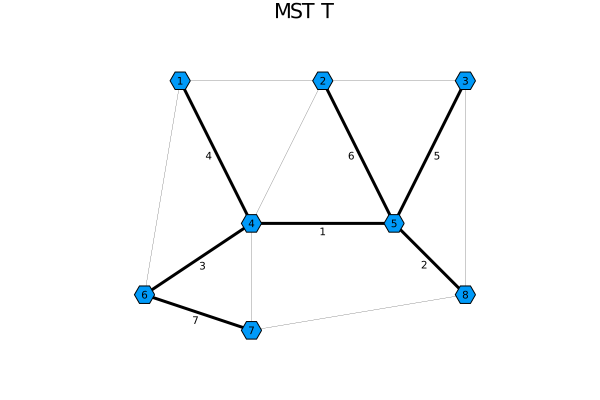

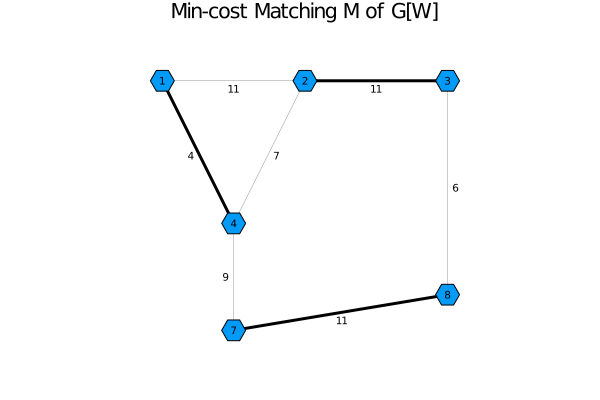

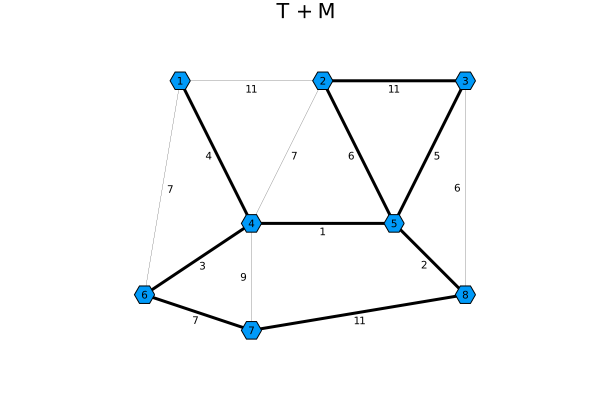

c(T): 1 + 2 + 3 + 4 + 5 + 6 + 7 = 28
deg(4) = 3
deg(5) = 4
deg(8) = 1
deg(6) = 2
deg(1) = 1
deg(3) = 1
deg(2) = 1
deg(7) = 1
W (odd-degree nodes in T): 4, 8, 1, 3, 2, 7
Matching M:
7 <=> 8
2 <=> 3
1 <=> 4
c(M): 11 + 11 + 4 = 26
Combined T + M:
1 <=> 4
2 <=> 3
7 <=> 8
6 <=> 7
2 <=> 5
3 <=> 5
4 <=> 6
5 <=> 8
4 <=> 5


In [314]:
C = Christofides(mg; show_graphs=true, verbose=true, elb=false, elo=0.015, curvature=0);

In [ ]:
tour = C[:];
remove!(Edge(4, 6), tour);
push!(tour, Edge(6, 1));

remove!(Edge(2, 5), tour);
remove!(Edge(4, 5), tour);
push!(tour, Edge(4, 2));

Tour: 
1 <-> 4 <-> 2 <-> 3 <-> 5 <-> 8 <-> 7 <-> 6 <-> 1
Cost of Christofide's Tour: 4.0 + 7.0 + 11.0 + 5.0 + 2.0 + 11.0 + 7.0 + 7.0 = 54.0


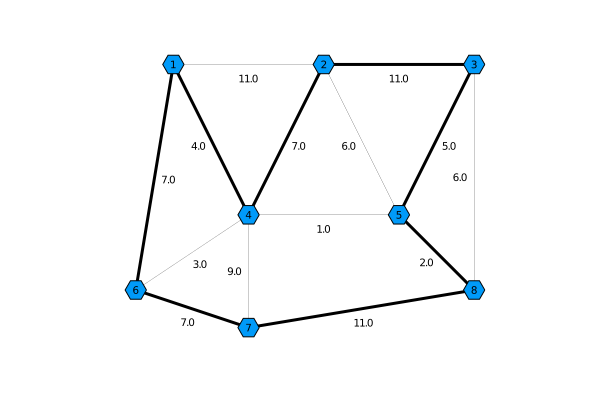

In [323]:
# tour = C[:];
# remove!(Edge(4, 6), tour);
# push!(tour, Edge(6, 1));

# remove!(Edge(2, 5), tour);
# remove!(Edge(4, 5), tour);
# push!(tour, Edge(4, 2));

println("Tour: ")
nodes = tour[:];
path = [1];
while !isempty(nodes)
    curr = last(path);
    next = remove!(Edge(1, 2), nodes; condition=(e)->incident(curr, e));
    if isempty(next)
        push!(path, 1)
        break;
    end
    edge = next[1];
    curr = (edge.src == curr ? edge.dst : edge.src)
    push!(path, curr)
end
push!(path, 1)
println(join(path, " <-> "))

tour = connect(path);

println("Cost of Christofide's Tour: " * sum_str(wts(tour, wd)))

plot_fixed(mg; ew=emphasize(tour; out_weight=0.2), el=wd, curvature=0, elb=false, elo=0.025)